In [1]:
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import alpaca_trade_api as tradeapi
%matplotlib inline

In [2]:
# Load .env enviroment variables
from dotenv import load_dotenv
load_dotenv()
# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version="v2")


In [3]:
# Get all Asstes
assets = api.list_assets()

# Keep only tradeable assets
tradeable = [asset for asset in assets if asset.tradable ]
#tradeable

In [4]:
# Create a new empty DataFrame
asset_info_df = pd.DataFrame()
asset_info_df["symbol"] = pd.Series([asset.symbol for asset in assets])
#asset_info_df.sort_values("symbol", inplace=True)

# Display the first 10 asset tickers
asset_info_df.head(10)

,symbol
0,ABEV
1,BZUN
2,NEM
3,MA
4,NET
5,V
6,DLTR
7,WMT
8,HUYA
9,CCXI


In [5]:
# Set the ticker
ticker = input("Enter the ticker to run the Monte Carlo Simulation")

# Set timeframe to "1D"
timeframe = "1D"

# Set start and end datetimes of 1 year, between now and 365 days ago.
start_date = pd.Timestamp("2019-03-20", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-03-20", tz="America/New_York").isoformat()

# Get 1 year"s worth of historical data for the desired stock
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
).df

df.tail()

Enter the ticker to run the Monte Carlo Simulation BNS


BNS                              
                            open   high    low  close   volume
2020-03-16 00:00:00-04:00  36.87  40.19  36.77  37.58  3067294
2020-03-17 00:00:00-04:00  38.08  39.27  35.92  37.91  2086529
2020-03-18 00:00:00-04:00  36.14  36.66  33.09  34.93  2322084
2020-03-19 00:00:00-04:00  34.24  35.21  33.18  35.04  1783683
2020-03-20 00:00:00-04:00  36.27  38.44  34.12  34.82  2206107

In [6]:
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


# Use the drop function to drop extra columns
df.drop(columns=["open", "high", "low", "volume"], inplace=True)


# Since this is daily data, we can keep only the date (remove the time) component of the data
df.index = df.index.date

df.tail()

,close
2020-03-16,37.58
2020-03-17,37.91
2020-03-18,34.93
2020-03-19,35.04
2020-03-20,34.82


In [7]:
# Use the `pct_change` function to calculate daily returns of BB
daily_returns = df.pct_change()

# Use the `mean` function to calculate the mean of daily returns for BB
avg_daily_return = daily_returns.mean()["close"]

# Use the `std` function to calculate the standard deviation of daily returns for BB
std_dev_daily_return = daily_returns.std()["close"]

In [8]:
# Set number of trading days and get last closing price of stoock from DataFrame
num_simulations = 1000
num_trading_days = 81 
stock_last_price = df["close"][-1]

# Initialize empty DataFrame to hold simulated prices for each simulation
simulated_price_df = pd.DataFrame()

# Run the simulation of projecting stock prices for the next trading year, `1000` times
for n in range(num_simulations):
    # Initialize the simulated prices list with the last closing price of TSLA
    simulated_ticker_prices = [stock_last_price]

        # Simulate the returns for 81  trading days (till 20th july 2020)
    for i in range(num_trading_days):
        # Calculate the simulated price using the last price within the list
        simulated_price = simulated_ticker_prices[-1] * (1 + np.random.normal(avg_daily_return, std_dev_daily_return))
        # Append the simulated price to the list
        simulated_ticker_prices.append(simulated_price)
    
    # Append the simulated prices of each simulation to DataFrame
    simulated_price_df[f"Simulation {n+1}"] = pd.Series(simulated_ticker_prices)

# Print head of DataFrame
simulated_price_df.head()

,Simulation 1,Simulation 2,Simulation 3,Simulation 4,Simulation 5,Simulation 6,Simulation 7,Simulation 8,Simulation 9,Simulation 10,...,Simulation 991,Simulation 992,Simulation 993,Simulation 994,Simulation 995,Simulation 996,Simulation 997,Simulation 998,Simulation 999,Simulation 1000
0,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,...,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000,34.820000
1,34.120580,33.313524,35.077563,34.297111,35.084707,34.590232,35.183739,35.135480,35.412707,34.895879,...,34.096655,34.624127,35.140297,34.751887,34.446920,35.297120,34.377994,34.813531,34.784175,35.932865
2,34.008868,34.284931,34.751625,33.005854,34.865819,34.784897,35.025806,34.529383,34.992228,33.377442,...,33.792648,33.688405,35.748392,34.532406,34.510097,35.152131,33.560277,34.598952,34.353622,35.310077
3,35.264404,33.736163,35.649610,33.616342,32.817460,34.883468,34.713128,33.956693,33.341813,34.051865,...,33.066514,34.980181,36.508664,35.574118,33.642561,35.943028,32.945078,33.657381,35.198424,35.581861
4,34.526965,33.423791,34.879575,34.622016,31.730181,34.290871,34.106494,33.824295,33.136656,34.948591,...,33.475895,34.125510,37.891081,35.325186,33.165188,36.454934,32.457095,34.211989,35.519142,35.082318


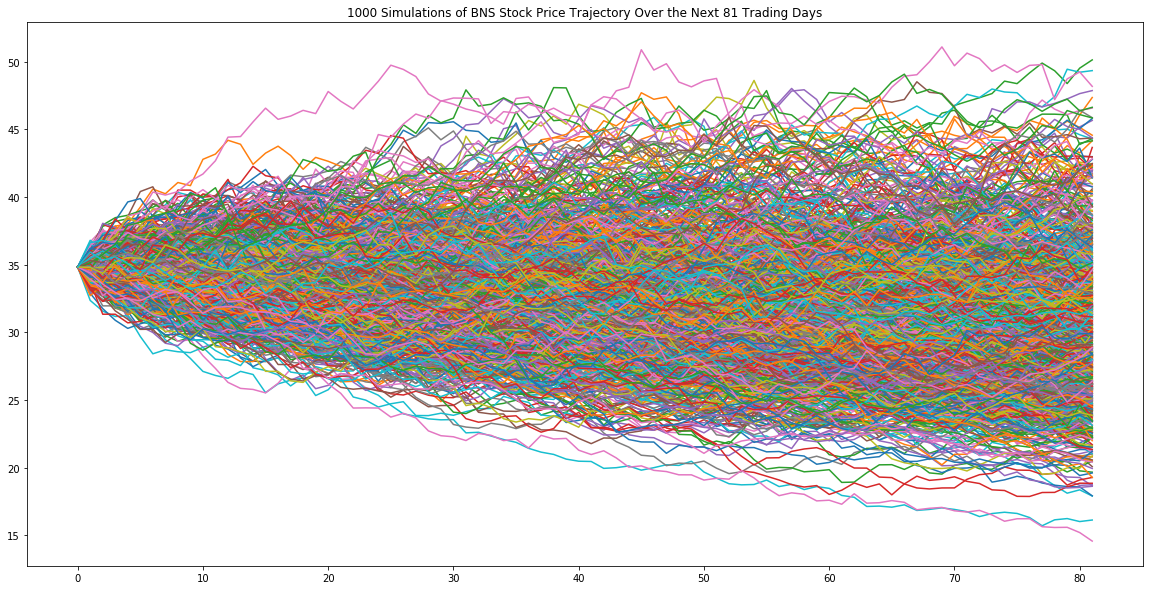

In [9]:
# Use the `plot` function to plot the trajectory of given stock based on a 81 trading day simulation
plot_title = f"{n+1} Simulations of {ticker} Stock Price Trajectory Over the Next 81 Trading Days"
simulated_price_df.plot(legend=None, title=plot_title, figsize =[20,10])

In [10]:
# Select the last row for projecting stock prices (prices of each simulation on the last simulated trading day)
simulated_ending_prices = simulated_price_df.iloc[-1, :]
simulated_ending_prices.head()

Simulation 1    23.542825
Simulation 2    32.217352
Simulation 3    39.251639
Simulation 4    31.507023
Simulation 5    29.082680
Name: 81, dtype: float64

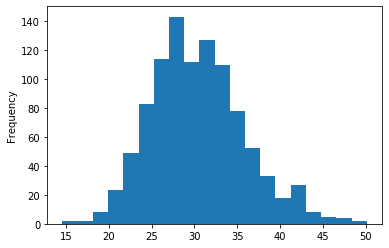

In [11]:
# Use the `plot` function to plot a frequency distribution of simulated ending prices
simulated_ending_prices.plot(kind='hist', bins=20)

In [12]:
# Use the `value_counts` function to create the frequency distribution and 
# sort the data into 20 bins. Divide the value counts of each bin by the total
# number of prices to return the probability of each range
simulated_ending_prices.value_counts(bins=20) / len(simulated_ending_prices)

(27.017, 28.795]    0.143
(30.572, 32.35]     0.127
(25.24, 27.017]     0.114
(28.795, 30.572]    0.112
(32.35, 34.127]     0.110
(23.463, 25.24]     0.083
(34.127, 35.904]    0.078
(35.904, 37.682]    0.052
(21.685, 23.463]    0.049
(37.682, 39.459]    0.033
(41.237, 43.014]    0.027
(19.908, 21.685]    0.023
(39.459, 41.237]    0.018
(43.014, 44.791]    0.008
(18.13, 19.908]     0.008
(44.791, 46.569]    0.005
(46.569, 48.346]    0.004
(16.353, 18.13]     0.002
(48.346, 50.124]    0.002
(14.539, 16.353]    0.002
Name: 81, dtype: float64

In [13]:
# Use the `quantile` function to calculate the 95% confidence interval for simulated ending prices
confidence_interval = simulated_ending_prices.quantile(q=[0.025, 0.975])
confidence_interval

0.025    21.246730
0.975    42.366056
Name: 81, dtype: float64

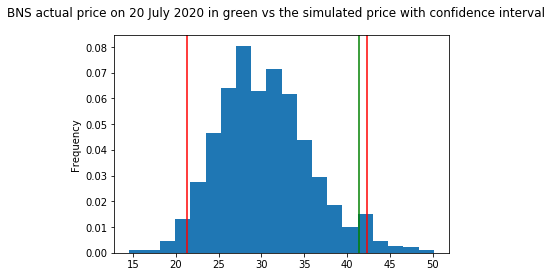

In [14]:
# Use the `plot` function to create a probability distribution histogram of simulated ending prices
# with markings for a 95% confidence interval
plt.figure();
simulated_ending_prices.plot(kind='hist', density=True, bins=20)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')

#Plot the actual price on 20th July of the stock

# Set timeframe to "1D"
timeframe = "1D"

# Set the dates for the price of the desired stock for 20 July 2020
start_date = pd.Timestamp("2020-07-19", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2020-07-20", tz="America/New_York").isoformat()

# Get actual stock price for the desired stock on 20th July 2020
df = api.get_barset(
    ticker,
    timeframe,
    limit=None,
    start=start_date,
    end=end_date,
    after=None,
    until=None,
    ).df

title_plot = (f"{ticker} actual price on 20 July 2020 in green vs the simulated price with confidence interval")
plt.suptitle(title_plot)
# Drop Outer Table Level
df = df.droplevel(axis=1, level=0)


actual_price = df["close"]

plt.axvline(actual_price.iloc[0], color='g')
